# Predicting Movie Revenue from Pre‑Release Features (The Movies Dataset / Kaggle)

## Introduction
This Jupyter notebook is part of the final project for the **Machine Learning** course at **GISMA University of Applied Sciences**.  
The goal is to predict a movie’s **box‑office revenue** using only **pre‑release information** (features available before the movie is released), such as budget, runtime, genres, release year, and historical “track record” features for cast and key crew roles.

The dataset used in this project is publicly available on Kaggle: **“The Movies Dataset” (Rounak Banik)**. The metadata includes movie attributes (e.g., budget, runtime, genres, release date) plus cast/crew lists.

Predicting revenue is challenging because revenues are **highly skewed** and influenced by many interacting factors. To handle skewness, I model **log1p(revenue)** and later convert predictions back to the revenue scale.  
Finally, I interpret the model output as a **revenue interval** (a practical range) rather than a single point estimate.



## Abstract (What this notebook delivers)
- **Task:** Supervised regression to predict **log1p(revenue)**.
- **Input features:** Only **pre‑release** attributes + **time‑aware historical aggregates** for top cast and key crew roles.
- **Train/Test split:** **Temporal split** to mimic real forecasting (train: release_year < 2015, test: ≥ 2015).
- **Model selection:** Compare multiple regressors using cross‑validation on the **train** period only.
- **Final model:** `HistGradientBoostingRegressor` (best overall on the held‑out test set in this project).
- **Final test performance (log scale):** MAE ≈ **0.26** (typical multiplicative error about **×/÷ 1.30**).

#shoudl I keep it???? -->
### Notebook pipeline (high level)
1) Load & merge datasets  
2) Clean data & remove leakage columns  
3) Feature engineering (genres + cast/crew historical aggregates)  
4) Build final feature matrix + encode categoricals  
5) Temporal train/test split  
6) Model selection + final evaluation  


## 1. Install Dependencies

In [20]:
!pip install -q kagglehub
!pip install -q pandas
!pip install -q numpy
!pip install -q scikit-learn
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q tqdm joblib tqdm-joblib


## 2. Import Libraries

In [21]:
import kagglehub

import os
import ast

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from joblib import parallel_backend
from tqdm_joblib import tqdm_joblib

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor


## 3. Data Preprocessing:



### 3.1. File(Data) Loading

The dataset is loaded programmatically from Kaggle using Kaggle Hub to ensure full reproducibility without requiring authentication or local file dependencies.

In [22]:
dataset_path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")
print("Path to dataset files:", dataset_path)
print("Dataset Filename:", os.listdir(dataset_path)[0])

Using Colab cache for faster access to the 'the-movies-dataset' dataset.
Path to dataset files: /kaggle/input/the-movies-dataset
Dataset Filename: ratings.csv


### 3.2 Load Dataset



In [23]:
movies_path  = os.path.join(dataset_path, "movies_metadata.csv")
credits_path = os.path.join(dataset_path, "credits.csv")

movies = pd.read_csv(movies_path, low_memory=False)
credits = pd.read_csv(credits_path)

print("movies:", movies.shape)
print("credits:", credits.shape)


movies: (45466, 24)
credits: (45476, 3)


### 3.3. Clean and normalize the join key (id)

The "movies_metadata.csv" sometimes contains non-numeric IDs, so I convert safely.
I did that and in this moment that I checked and tried to normalize data 3 movies out of 45466 reduced from the main list but I'm keeping it anyway because it's a good approach to do.

In [24]:
movies["id"] = pd.to_numeric(movies["id"], errors="coerce")
credits["id"] = pd.to_numeric(credits["id"], errors="coerce")

movies = movies.dropna(subset=["id"]).copy()
credits = credits.dropna(subset=["id"]).copy()

movies["id"] = movies["id"].astype(int)
credits["id"] = credits["id"].astype(int)

print("movies after id cleaning:", movies.shape)
print("credits after id cleaning:", credits.shape)



movies after id cleaning: (45463, 24)
credits after id cleaning: (45476, 3)


### 3.4. Check for duplicates and remove them

In [25]:
print("Duplicate ids in movies:", movies["id"].duplicated().sum())
print("Duplicate ids in credits:", credits["id"].duplicated().sum())
credits = credits.drop_duplicates(subset=["id"]).copy()


Duplicate ids in movies: 30
Duplicate ids in credits: 44


### 3.5. Merging credits with movie metadata

I chose left join on these files because it keeps all movies from metadata, adds cast/crew where available to have a unified table with all the features that I think are useful.

In [26]:
df = movies.merge(credits, on="id", how="left")

print("Merged df:", df.shape)
df.head(2)


Merged df: (45463, 26)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."


### 3.6. Data profiling and initial cleaning

In [27]:
print("Dataset shape:", df.shape)
df.info()

Dataset shape: (45463, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45463 entries, 0 to 45462
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45463 non-null  object 
 1   belongs_to_collection  4491 non-null   object 
 2   budget                 45463 non-null  object 
 3   genres                 45463 non-null  object 
 4   homepage               7779 non-null   object 
 5   id                     45463 non-null  int64  
 6   imdb_id                45446 non-null  object 
 7   original_language      45452 non-null  object 
 8   original_title         45463 non-null  object 
 9   overview               44509 non-null  object 
 10  popularity             45460 non-null  object 
 11  poster_path            45077 non-null  object 
 12  production_companies   45460 non-null  object 
 13  production_countries   45460 non-null  object 
 14  release_date           4537

### 3.6.1 Missing values

In [28]:
missing = df.isnull().mean().sort_values(ascending=False)
missing[missing > 0].head(20)

,0
belongs_to_collection,0.901216
homepage,0.828894
tagline,0.551020
overview,0.020984
poster_path,0.008490
runtime,0.005719
release_date,0.001914
status,0.001848
imdb_id,0.000374
original_language,0.000242


### 3.6.2 Dropping irrelevant and leakage‑prone columns (before feature engineering)

Before building features, I remove columns that are either:
- **Irrelevant** for pre‑release forecasting (e.g., poster paths, free‑text tagline), or
- **Leakage / post‑release proxies**, such as vote statistics that strongly depend on audience reactions after release.


In [29]:
IRRELEVANT_COLS = [
    "homepage",
    "belongs_to_collection",
    "overview",
    "poster_path",
    "imdb_id",
    "original_title",
    "video",
    "tagline",
]

LEAKING_COLS = [
    "popularity",
    "vote_average",
    "vote_count",
]

CLEANING_DROP_COLS = IRRELEVANT_COLS + LEAKING_COLS

df = df.drop(columns=[c for c in CLEANING_DROP_COLS if c in df.columns])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45463 entries, 0 to 45462
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 45463 non-null  object 
 1   budget                45463 non-null  object 
 2   genres                45463 non-null  object 
 3   id                    45463 non-null  int64  
 4   original_language     45452 non-null  object 
 5   production_companies  45460 non-null  object 
 6   production_countries  45460 non-null  object 
 7   release_date          45376 non-null  object 
 8   revenue               45460 non-null  float64
 9   runtime               45203 non-null  float64
 10  spoken_languages      45460 non-null  object 
 11  status                45379 non-null  object 
 12  title                 45460 non-null  object 
 13  cast                  45462 non-null  object 
 14  crew                  45462 non-null  object 
dtypes: float64(2), int6

## 4. Feature Engineering and Target Definition

### 4.1 Fix data types

In [30]:
df["budget"] = pd.to_numeric(df["budget"], errors="coerce")
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df = df.dropna(subset=["budget", "revenue", "release_date", "runtime"]).copy()


### 4.2 Genre multi-hot encoding

In [31]:
def extract_genre_names(genres_str):
    try:
        genres = ast.literal_eval(genres_str)
        return [g["name"] for g in genres]
    except:
        return []

df["genre_list"] = df["genres"].apply(extract_genre_names)

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df["genre_list"])

genre_df = pd.DataFrame(
    genre_encoded,
    columns=[f"genre_{g.lower()}" for g in mlb.classes_],
    index=df.index
)

df = pd.concat([df, genre_df], axis=1)
df = df.drop(columns=["genres", "genre_list"])

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 45130 entries, 0 to 45462
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  45130 non-null  object        
 1   budget                 45130 non-null  int64         
 2   id                     45130 non-null  int64         
 3   original_language      45119 non-null  object        
 4   production_companies   45130 non-null  object        
 5   production_countries   45130 non-null  object        
 6   release_date           45130 non-null  datetime64[ns]
 7   revenue                45130 non-null  float64       
 8   runtime                45130 non-null  float64       
 9   spoken_languages       45130 non-null  object        
 10  status                 45054 non-null  object        
 11  title                  45130 non-null  object        
 12  cast                   45129 non-null  object        
 13  crew  

### 4.3 Cast star-power features (top‑5 billed actors)

In this step, I introduce cast star-power features based on the historical performance of the top-billed actors in each movie.

For each movie, only the first five actors listed in the cast are considered (That's just my choice and it could be more but for now and the scale of project I picked 5 stars).

The dataset lists actors in an ordered way, where more famous actors usually appear first, and the rest follow in this order.

To avoid target leakage, actor performance is computed in a time-aware manner. For each actor, only revenues from movies released before the current movie are used. From this history, two statistics are derived:


*   the median past revenue, which provides a robust estimate of typical commercial performance, and
*  the number of past movies, which captures experience and visibility.

I chose the median instead of the mean to reduce bias in the data. Using the mean could be strongly affected by a single extreme case, such as one very unsuccessful movie or one extreme blockbuster in an actor’s past. In some cases, a movie may succeed because of other leading actors, while the selected actor appears only in a lower billing position (for example, fifth in the cast because I picked first 5 actors). To avoid these misleading effects and obtain a more stable representation of typical performance, I used the median.

These actor-level statistics are then aggregated at the movie level across the top-five actors. The median is used for revenue aggregation to reduce the influence of extreme blockbuster outliers, while past movie counts are summed to reflect overall cast experience.

The result is a compact set of numerical features that encode cast strength using only information that would have been available prior to a movie’s release.

In [32]:
required_cols = ["id", "cast", "revenue", "release_date"]
missing_required = [c for c in required_cols if c not in df.columns]
if missing_required:
    raise ValueError(f"df is missing required columns: {missing_required}")

# here just make sure movie released and not rumored
if "status" in df.columns:
    df = df[df["status"] == "Released"].copy()

df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df = df.dropna(subset=["release_date"]).copy()
df["release_year"] = df["release_date"].dt.year.astype(int)


df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce").fillna(0)

# -----------------------------
# 0.1) CLEAN UP any previous merge artifacts (_x/_y) + old feature cols
# -----------------------------
# DROP_PREV = [
#     "top5_cast_median_past_revenue",
#     "top5_cast_total_past_movies",
# ]
# df = df.drop(columns=[c for c in DROP_PREV if c in df.columns], errors="ignore")


# here I just extract top 5 actors of each movie
def parse_top5_actor_ids(cast_str, k=5):
    if pd.isna(cast_str):
        return []
    try:
        cast_list = ast.literal_eval(cast_str)
        if not isinstance(cast_list, list):
            return []
        ids = []
        for p in cast_list[:k]:
            if isinstance(p, dict) and p.get("id") is not None:
                ids.append(int(p["id"]))
        return ids
    except Exception:
        return []

df["top5_actor_ids"] = df["cast"].apply(parse_top5_actor_ids)


# build actor_movies table (movie x actor rows) from top5 actors
actor_movies = df[["id", "release_year", "revenue", "top5_actor_ids"]].explode("top5_actor_ids")
actor_movies = actor_movies.dropna(subset=["top5_actor_ids"]).copy()
actor_movies = actor_movies.rename(columns={"top5_actor_ids": "actor_id"})
actor_movies["actor_id"] = actor_movies["actor_id"].astype(int)

actor_movies_hist = actor_movies[actor_movies["revenue"] > 0].copy()
actor_movies_hist = actor_movies_hist.sort_values(["actor_id", "release_year", "id"])

# actor past median revenue
actor_movies_hist["actor_past_median_revenue"] = (
    actor_movies_hist
    .groupby("actor_id")["revenue"]
    .expanding()
    .median()
    .shift(1)
    .reset_index(level=0, drop=True)
)

# past movie count for each actor (how many prior movies observed)
actor_movies_hist["actor_past_movie_count"] = actor_movies_hist.groupby("actor_id").cumcount()


movie_star_power = actor_movies_hist.groupby("id").agg(
    top5_cast_median_past_revenue=("actor_past_median_revenue", "median"),
    top5_cast_total_past_movies=("actor_past_movie_count", "sum"),
).reset_index()

# merge actors table to their movies
df = df.merge(movie_star_power, on="id", how="left")

df["top5_cast_median_past_revenue"] = df["top5_cast_median_past_revenue"].fillna(0)
df["top5_cast_total_past_movies"] = df["top5_cast_total_past_movies"].fillna(0)





### 4.4 Crew track‑record features (director, writer, producer)

In this step, I apply the same approach used in Section 4.3 to key crew roles, specifically the director, writer, and producer. I believe these roles have a strong influence on movie revenue; for example, we would normally expect movies directed by Christopher Nolan to generate higher revenue.

For each movie, crew members in these roles are identified, and their historical performance is calculated in a time-aware manner, using only movies released before the current one to avoid target leakage as I discussed in last section.

In [33]:


DROP_PREV_CREW = [
    "director_past_median_revenue",
    "director_past_movie_count",
    "writer_past_median_revenue",
    "writer_past_movie_count",
    "producer_past_median_revenue",
    "producer_past_movie_count",
]
df = df.drop(columns=[c for c in DROP_PREV_CREW if c in df.columns], errors="ignore")


def parse_crew(crew_str):
    if pd.isna(crew_str):
        return []
    try:
        crew = ast.literal_eval(crew_str)
        return crew if isinstance(crew, list) else []
    except Exception:
        return []

df["crew_parsed"] = df["crew"].apply(parse_crew)

# extract those roles ids
def extract_role_ids(crew, roles):
    ids = []
    for p in crew:
        if isinstance(p, dict) and p.get("job") in roles and p.get("id") is not None:
            ids.append(int(p["id"]))
    return ids

DIRECTOR_ROLES = {"Director"}
WRITER_ROLES = {"Writer", "Screenplay", "Story", "Original Story"}
PRODUCER_ROLES = {"Producer", "Executive Producer", "Co-Producer", "Associate Producer"}

df["director_ids"] = df["crew_parsed"].apply(lambda x: extract_role_ids(x, DIRECTOR_ROLES))
df["writer_ids"]   = df["crew_parsed"].apply(lambda x: extract_role_ids(x, WRITER_ROLES))
df["producer_ids"] = df["crew_parsed"].apply(lambda x: extract_role_ids(x, PRODUCER_ROLES))


def build_role_history(df, id_col, role_name):
    role_movies = df[["id", "release_year", "revenue", id_col]].explode(id_col)
    role_movies = role_movies.dropna(subset=[id_col]).copy()
    role_movies = role_movies.rename(columns={id_col: "person_id"})
    role_movies["person_id"] = role_movies["person_id"].astype(int)

    role_movies = role_movies[role_movies["revenue"] > 0].copy()
    role_movies = role_movies.sort_values(["person_id", "release_year", "id"])

    role_movies[f"{role_name}_past_median_revenue"] = (
        role_movies
        .groupby("person_id")["revenue"]
        .expanding()
        .median()
        .shift(1)
        .reset_index(level=0, drop=True)
    )

    role_movies[f"{role_name}_past_movie_count"] = role_movies.groupby("person_id").cumcount()

    agg = role_movies.groupby("id").agg(
        **{
            f"{role_name}_past_median_revenue": (f"{role_name}_past_median_revenue", "median"),
            f"{role_name}_past_movie_count": (f"{role_name}_past_movie_count", "sum"),
        }
    ).reset_index()

    return agg


director_agg = build_role_history(df, "director_ids", "director")
writer_agg   = build_role_history(df, "writer_ids",   "writer")
producer_agg = build_role_history(df, "producer_ids", "producer")

# merge tables of each role to the original movie table
df = df.merge(director_agg, on="id", how="left")
df = df.merge(writer_agg,   on="id", how="left")
df = df.merge(producer_agg, on="id", how="left")


for col in DROP_PREV_CREW:
    if col in df.columns:
        df[col] = df[col].fillna(0)


df = df.drop(
    columns=["crew_parsed", "director_ids", "writer_ids", "producer_ids"],
    errors="ignore"
)

print("✅ Added crew historical aggregate features:")
display(df[
    [
        "director_past_median_revenue",
        "director_past_movie_count",
        "writer_past_median_revenue",
        "writer_past_movie_count",
        "producer_past_median_revenue",
        "producer_past_movie_count",
    ]
].describe())


✅ Added crew historical aggregate features:


,director_past_median_revenue,director_past_movie_count,writer_past_median_revenue,writer_past_movie_count,producer_past_median_revenue,producer_past_movie_count
count,4.469600e+04,44696.000000,4.469600e+04,44696.000000,4.469600e+04,44696.000000
mean,8.843510e+06,0.340948,9.657402e+06,0.400707,8.140764e+06,2.141556
std,4.414280e+07,1.553616,4.489788e+07,2.009906,3.718816e+07,10.685729
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
50%,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
75%,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
max,1.274219e+09,44.000000,1.023784e+09,54.000000,1.089366e+09,251.000000


## 5. Feature Matrix Preparation

In this section I build the final modeling dataset (**df_model**), define the target label (**y**), and construct the feature matrix (**X**).
At this point, all cleaning and feature engineering steps are complete, so the remaining work is about turning the table into a purely numerical format that our model can learn from.

**What happens in this section**
- Select / drop non-model columns (IDs, raw JSON strings, and high-cardinality text fields)
- Define the target as **log1p(revenue)** to reduce skewness
- One-hot encode remaining low-cardinality categorical features


### 5.1 Final Feature Matrix and Target Construction



In [34]:
df_model = df.copy()

# Keep only movies with observed revenue (target must be defined)
df_model = df_model[df_model["revenue"] > 0].copy()

# Target: log-transformed revenue to reduce skewness
df_model["log_revenue"] = np.log1p(df_model["revenue"])
y = df_model["log_revenue"]

DROP_COLS = [
    # target
    "revenue", "log_revenue",

    # identifiers / raw text
    "id", "title", "release_date",
    "cast", "crew",

    # high-cardinality categoricals (kept simple for this course project)
    "production_companies", "production_countries", "spoken_languages",

    # raw JSON column (genres already expanded into multi-hot columns earlier)
    "genres",
]

X = df_model.drop(columns=[c for c in DROP_COLS if c in df_model.columns], errors="ignore").copy()


bad_cols = [
    c for c in X.columns
    if X[c].apply(lambda v: isinstance(v, (list, dict, set, tuple))).any()
]
X = X.drop(columns=bad_cols, errors="ignore")
print("Dropped non-tabular columns:", bad_cols)

# handle missing numeric values
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
X[num_cols] = X[num_cols].fillna(0)

# One-hot encode remaining categorical features (low-cardinality)
cat_cols = X.select_dtypes(include=["object"]).columns
print("Categorical columns encoded:", cat_cols.tolist())
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print("✅ Final shapes -> X:", X.shape, "| y:", y.shape)


Dropped non-tabular columns: ['top5_actor_ids']
Categorical columns encoded: ['adult', 'original_language', 'status']
✅ Final shapes -> X: (7389, 74) | y: (7389,)


## 6. Split Train and Test
In this step, the dataset is split into training and test sets using a time-based split rather than a random split.

Movies released before 2015 are used for training, while movies released in 2015 and later are kept for testing. This choice reflects a realistic prediction scenario, where a model is trained on historical data and then used to estimate the revenue of future movies.

Using a time-based split helps prevent data leakage, since information from newer movies is not allowed to influence the training process. It also better matches the real-world use case of this project, where revenue predictions are made for movies that have not yet been released.

I did not tune the split year to optimize performance. The goal was to simulate a realistic forecasting scenario with a clear time boundary, and 2015 provided a good balance between historical coverage and test set size (I showed it below and the test size is 9.55% of the full dataset).

In [39]:
# Use release_year for a temporal split (realistic forecasting setup)
train_idx = df_model["release_year"] < 2015
test_idx  = df_model["release_year"] >= 2015

total_samples = len(df_model)
test_samples = test_idx.sum()

test_percentage = (test_samples / total_samples) * 100

print("Test percentage:", test_percentage)

X_train = X.loc[train_idx].copy()
X_test  = X.loc[test_idx].copy()
y_train = y.loc[train_idx].copy()
y_test  = y.loc[test_idx].copy()

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Test percentage: 9.554743537691163
Train shape: (6683, 74)
Test shape: (706, 74)


## 7. Model selection and evaluation

In this section, I compare a small set of models using cross-validation **only on the training period**, then evaluate the best model once on the held-out test period.


### 7.1 Feature scaling

Tree-based models (Random Forest, Gradient Boosting) do **not** require feature scaling.  
For linear models (e.g., Ridge), scaling is applied **inside the sklearn Pipeline** during model selection to avoid data leakage.


### 7.2 Model selection with cross‑validation (GridSearchCV)
Model Selection Rationale

Here multiple regression models are evaluated to understand how different modeling assumptions affect revenue prediction. Each model is chosen for a specific reason, ranging from simple baselines to more expressive non-linear methods.

Ridge Regression is used as a linear baseline model. It extends standard linear regression by adding regularization, which helps control overfitting when the number of features is large. Ridge regression also provides a strong reference point to compare more complex models against a simple, interpretable approach.

Random Forest Regressor is included to capture non-linear relationships and feature interactions that linear models cannot represent. By combining many decision trees, random forests are robust to noise and can model complex patterns in tabular data without requiring strong assumptions about feature distributions.

Histogram-based Gradient Boosting Regressor is selected as a more advanced ensemble method that incrementally improves predictions by correcting previous errors. This model is well-suited for large tabular datasets, handles non-linearities efficiently, and often achieves strong performance with relatively little feature scaling or manual tuning.

Together, these models provide a balanced comparison between interpretability, flexibility, and predictive performance, allowing the final model choice to be based on empirical results rather than assumptions.

And for validation I went with K-Fold cross-validation as a balanced and practical approach. A single hold-out split can lead to unstable results depending on how the data is divided, while K-Fold reduces this risk by averaging performance across multiple folds. Leave-one-out validation is also a computationally expensive method for a dataset of this size and does not provide clear advantages here. Although the data has a time component, the temporal dependency is already handled by the train–test split, and K-Fold cross-validation within the training set offers a good trade-off between reliability and efficiency for model selection.

In [36]:

models = []

# ridge
pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(random_state=42))
])
param_grid_ridge = {"ridge__alpha": [0.1, 1.0, 10.0, 50.0]}
models.append(("Ridge", pipe_ridge, param_grid_ridge))

# random Forest
pipe_rf = Pipeline([
    ("rf", RandomForestRegressor(random_state=42, n_jobs=-1))
])
param_grid_rf = {
    "rf__n_estimators": [200, 400],
    "rf__max_depth": [10, 15, 20],
    "rf__min_samples_leaf": [5, 10, 20],
    "rf__max_features": ["sqrt", 0.5],
}
models.append(("Random Forest", pipe_rf, param_grid_rf))

# histGradientBoosting
pipe_hgb = Pipeline([
    ("hgb", HistGradientBoostingRegressor(random_state=42))
])
param_grid_hgb = {
    "hgb__max_depth": [4, 6, 8],
    "hgb__learning_rate": [0.03, 0.05, 0.08],
    "hgb__max_iter": [200, 300, 500],
}
models.append(("HistGradientBoosting", pipe_hgb, param_grid_hgb))


cv = KFold(n_splits=3, shuffle=True, random_state=42)

def count_grid_fits(param_grid, cv):
    n = 1
    for v in param_grid.values():
        n *= len(v)
    return n * cv.get_n_splits()

selection_rows = []
best_estimators = {}

for name, pipe, param_grid in models:
    print(f"\n===== {name} =====")

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        refit=True,
        verbose=0
    )

    total = count_grid_fits(param_grid, cv)
    with tqdm_joblib(tqdm(total=total, desc=f"{name} fits")):
        grid.fit(X_train, y_train)

    best_cv_mae = -grid.best_score_
    best_estimators[name] = grid.best_estimator_

    y_pred = grid.best_estimator_.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    selection_rows.append({
        "model": name,
        "best_params": grid.best_params_,
        "cv_mae_log": best_cv_mae,
        "test_mae_log": test_mae,
        "test_rmse_log": test_rmse,
        "typical_mult_error": float(np.exp(test_mae)),
    })

results_df = pd.DataFrame(selection_rows).sort_values("test_mae_log")
display(results_df)

best_name = results_df.iloc[0]["model"]
best_estimator = best_estimators[best_name]

print("\n✅ Selected best model:", best_name)



===== Ridge =====


Ridge fits:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]


===== Random Forest =====


Random Forest fits:   0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]


===== HistGradientBoosting =====


HistGradientBoosting fits:   0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

,model,best_params,cv_mae_log,test_mae_log,test_rmse_log,typical_mult_error
2,HistGradientBoosting,"{'hgb__learning_rate': 0.03, 'hgb__max_depth':...",1.364270,1.389370,1.917493,4.012323
1,Random Forest,"{'rf__max_depth': 15, 'rf__max_features': 0.5,...",1.390572,1.400067,1.945226,4.055472
0,Ridge,{'ridge__alpha': 50.0},1.718328,1.770221,2.364226,5.872154



✅ Selected best model: HistGradientBoosting


## 8. Final model

In [37]:

final_model = HistGradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.05,
    max_iter=200,
    random_state=42
)

final_model.fit(X_train, y_train)


y_test_pred = final_model.predict(X_test)

final_mae = mean_absolute_error(y_test, y_test_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("🎯 FINAL MODEL PERFORMANCE")
print(f"MAE (log revenue):  {final_mae:.4f}")
print(f"RMSE (log revenue): {final_rmse:.4f}")

# Interpret error in original revenue scale
mult_error = np.exp(final_mae)
print(f"Typical multiplicative error: ÷{mult_error:.2f} to ×{mult_error:.2f}")



🎯 FINAL MODEL PERFORMANCE
MAE (log revenue):  1.3914
RMSE (log revenue): 1.9353
Typical multiplicative error: ÷4.02 to ×4.02


Basic stats for revenue (USD):
count    7.389000e+03
mean     6.895459e+07
std      1.465708e+08
min      1.000000e+00
25%      2.409225e+06
50%      1.690000e+07
75%      6.764269e+07
max      2.787965e+09
Name: revenue, dtype: float64

Skewness of raw revenue: 5.142066675225471


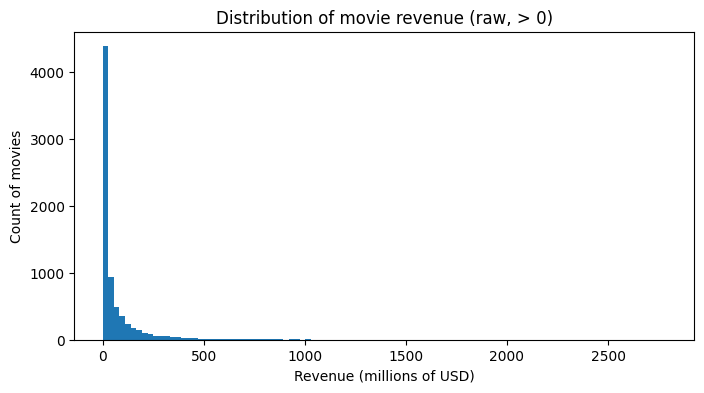

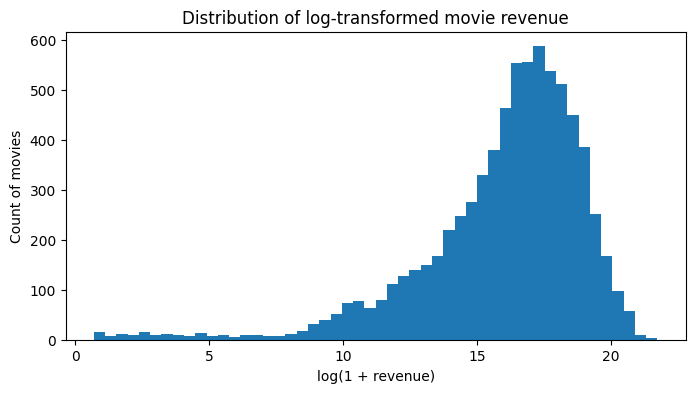

In [42]:
import matplotlib.pyplot as plt

# Keep only positive revenues (0s are often "missing" or not released)
rev = df["revenue"]
rev_pos = rev[rev > 0]

print("Basic stats for revenue (USD):")
print(rev_pos.describe())

print("\nSkewness of raw revenue:", rev_pos.skew())


plt.figure(figsize=(8, 4))
plt.hist(rev_pos / 1e6, bins=100)  # in millions for readability
plt.xlabel("Revenue (millions of USD)")
plt.ylabel("Count of movies")
plt.title("Distribution of movie revenue (raw, > 0)")
plt.show()


import numpy as np
rev_log = np.log1p(rev_pos)

plt.figure(figsize=(8, 4))
plt.hist(rev_log, bins=50)
plt.xlabel("log(1 + revenue)")
plt.ylabel("Count of movies")
plt.title("Distribution of log-transformed movie revenue")
plt.show()


### 8.1 Interpreting predictions as a revenue range

Because the model is trained on **log revenue**, the MAE on the log scale can be interpreted as an approximate **multiplicative error** on the original revenue scale.

If MAE = *e*, then a typical prediction is within roughly **×/÷ exp(e)** of the true value.  
I use this to produce a simple and interpretable revenue interval:
\[
\text{lower} = \hat{r} / \exp(\text{MAE}), \quad
\text{upper} = \hat{r} \times \exp(\text{MAE})
\]

> This is not a strict confidence interval; it is a practical “typical error band” based on test MAE.

## 9. Discussion and limitations (brief)
- The dataset contains noisy or missing values (especially for `budget` and `revenue`), and many films have zero/unknown revenue.
- Some strong drivers of revenue are **not available pre-release** (marketing spend, distribution strategy, competition, etc.).
- Star-power features are approximations based on billing order and historical revenues; they reduce sparsity but still cannot capture all real-world effects.

## 10. Conclusion
This notebook demonstrates a complete supervised learning pipeline for **movie revenue forecasting from pre-release features**, including careful handling of leakage via temporal splitting and time-aware historical aggregates for cast and crew.


In [38]:
# ============================================================
# 8.1 Example: convert predictions to revenue + typical error band
# ============================================================

# Predict log revenue and convert back to original scale
y_log_pred = final_model.predict(X_test)
rev_pred = np.expm1(y_log_pred)

# Typical multiplicative error band using MAE
mult = np.exp(final_mae)
rev_lower = rev_pred / mult
rev_upper = rev_pred * mult

examples = pd.DataFrame({
    "revenue_true": np.expm1(y_test.values),
    "revenue_pred": rev_pred,
    "pred_lower": rev_lower,
    "pred_upper": rev_upper,
}).head(10)

display(examples)


,revenue_true,revenue_pred,pred_lower,pred_upper
0,6.823301e+08,5.586794e+08,1.389627e+08,2.246089e+09
1,1.839877e+08,3.824553e+08,9.512973e+07,1.537606e+09
2,3.686941e+07,1.675690e+07,4.168015e+06,6.736868e+07
3,9.382076e+07,1.870238e+08,4.651921e+07,7.519019e+08
4,1.513529e+09,6.571656e+08,1.634596e+08,2.642039e+09
5,3.112569e+08,2.493950e+08,6.203308e+07,1.002656e+09
6,4.143515e+08,1.450060e+08,3.606796e+07,5.829756e+08
7,1.043995e+08,1.732833e+08,4.310150e+07,6.966605e+08
8,1.775294e+07,1.822072e+08,4.532118e+07,7.325378e+08
9,4.406035e+08,4.797905e+08,1.193403e+08,1.928928e+09
